# Overview
**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system for English-Irish translation where English is the source language and Irish is the target language. 

**Grading Policy** 
Assignment 2 is graded and will be worth 25% of your overall grade. This assignment is worth a total of 50 points distributed over the tasks below.  Please note that this is an individual assignment and you must not work with other students to complete this assessment. Any copying from other students, from student exercises from previous years, and any internet resources will not be tolerated. Plagiarised assignments will receive zero marks and the students who commit this act will be reported. Feel free to reach out to the TAs and instructors if you have any questions.

## Task 1 - Data Collection and Preprocessing (10 points)
## Task 1a. Data Loading (5 pts)
Dataset: https://www.dropbox.com/s/zkgclwc9hrx7y93/DGT-en-ga.txt.zip?dl=0 
*  Download a English-Irish dataset and decompress it. The `DGT.en-ga.en` file contains a list english sentences and `DGT.en-ga.ga` contains the paralell Irish sentences. Read both files into the Jupyter environment and load them into a pandas dataframe. 
* Randomly sample 12,000 rows.
* Split the sampled data into train (10k), development (1k) and test set (1k)

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

#reading lines from datasets for english and irish data
english_data = []
irish_data = []

#reading the data for irish and english data
#with open("/content/gdrive/MyDrive/NLP Assignment 2/DGT.en-ga.en") as file:
#    for line in file:
#        english_data.append(line)

#with open("/content/gdrive/MyDrive/NLP Assignment 2/DGT.en-ga.ga") as file:
#    for line in file:
#        irish_data.append(line)

english_data = pd.read_csv("/content/gdrive/MyDrive/NLP Assignment 2/DGT.en-ga.en",
                           sep='\t', names = ["Englishtext"])

irish_data = pd.read_csv("/content/gdrive/MyDrive/NLP Assignment 2/DGT.en-ga.ga",
                           sep='\t', names = ["Irishtext"])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.concat([english_data, irish_data], axis = 1)

In [ ]:
df = df.dropna()

In [ ]:
#storing the data in same frame for processing
#df = pd.DataFrame({"Englishtext" : english_data, "Irishtext" : irish_data})

In [ ]:
#calculating the lengths of strings for max sequence later
df["Irishlen"] = df["Irishtext"].apply(lambda x: len(x.split(" ")))
df["Englishlen"] = df["Englishtext"].apply(lambda x: len(str(x).split(" ")))

In [ ]:
df

,Englishtext,Irishtext,Irishlen,Englishlen
0,Procès-verbal of rectification to the Conventi...,Miontuairisc cheartaitheach maidir le Coinbhin...,28,27
1,(Official Journal of the European Union L 147 ...,(Iris Oifigiúil an Aontais Eorpaigh L 147 an 1...,20,12
2,This rectification has been carried out by mea...,Rinneadh an ceartúchán seo le miontuairisc che...,28,33
3,"On pages 33-34, Annex I:","Ar leathanaigh 33-34, Iarscríbhinn I:",5,5
4,the entries for the States below are rectified...,maidir leis na hiontrálacha le haghaidh na Stá...,14,10
...,...,...,...,...
181138,For the Council,"Airteagal 2.5 (Coimirce talmhaíochta), agus Ai...",12,3
181139,Position of the European Parliament of 31 Janu...,"ciallaíonn ‘idirthréimhse’, i ndáil le hearra ...",43,23
181140,Regulation (EU) No 1305/2013 of the European P...,Airteagal 18 (Coimirciú) d'Iarscríbhinn 2-C ma...,10,37
181141,Regulation (EU) 2017/2393 of the European Parl...,I rith na 10 mbliana tar éis theacht i bhfeidh...,35,107


In [ ]:
df = df[(df["Irishlen"] > 30) & (df['Englishlen'] > 30) & (df["Irishlen"] < 150) & (df['Englishlen'] < 150)]
df = df.sample(12000, random_state=42)

In [ ]:
dataset = df.reset_index()

In [ ]:
len(df)

12000

## Task 1b. Preprocessing (5 pts)
* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the following pre-processing steps:
  * Lowercase the text
  * Remove all punctuation
  * tokenize the text 
*  Build seperate vocabularies for each language. 
  * Assign each unique word an id value 
*Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language



In [ ]:
import re
from collections import Counter

# Your code here
class Preprocess:
    """
      functions:
        sentencetotags: add end and start tags
        preprocess: to lowercase words and remove punctuations
        tokenize : to generate tokens form sentences
        create_dict, wordtoidx : to generate dictonaries for index to word (englishwordtoindex) and word to idx(englishdict)
        encode_sentence : for word to token
        decode : for tokens to sentence
        print: to print corpus summary
    """
    def __init__(self, dataframe):
        self.dataframe = dataframe        
        self.englishwords = []
        self.irishwords = []
        self.english_valuecounts = {}
        self.irish_valuecounts = {}
        self.english_dict = {"PAD": 0, "<bof>": 1, "<eos>": 2}
        self.english_word2idx = {0: 'PAD', 1: "<bof>", 2 : "<eof>"}
        self.irish_dict = {"PAD": 0, "<bof>": 1, "<eos>": 2}
        self.irish_word2idx = {0: 'PAD', 1: "<bof>", 2 : "<eof>"}
        self.english_unique_words = 0
        self.irish_unique_words = 0
        self.english_word_count = 0
        self.irish_word_count = 0
        self.encoded_sentence_english = 0
        self.encoded_sentence_irish = 0
        
        
    #1. Add '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line.
    def sentenceTags(self):
        self.dataframe['Englishtext'] = self.dataframe['Englishtext'].apply(lambda x: '<bof> '+ x + ' <eos>')
        self.dataframe['Irishtext'] = self.dataframe['Irishtext'].apply(lambda x: '<bof> '+ x + ' <eos>')
        
        return self.dataframe
    
    #Lowercase the text
    #Remove all punctuation         
    def preprocess(self):
        #Lowercase the text
        self.dataframe['Englishtext'] = self.dataframe['Englishtext'].apply(lambda x: str(x).lower())
        self.dataframe['Irishtext'] = self.dataframe['Irishtext'].apply(lambda x: x.lower())
        
        #Remove all punctuation
        self.dataframe['Englishtext'] = self.dataframe['Englishtext'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        self.dataframe['Irishtext'] = self.dataframe['Irishtext'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
        
        return self.dataframe
        
    #tokenize the text
    def tokenize(self):
        self.dataframe['EnglishTokens'] = self.dataframe['Englishtext'].apply(lambda x: x.split(" "))
        self.dataframe['IrishTokens'] = self.dataframe['Irishtext'].apply(lambda x: x.split(" "))
        
        return self.dataframe
        
    #Assign each unique word an id value
    def create_dict(self):
        self.englishwords = self.dataframe['Englishtext'].str.cat().split(' ')
        self.irishwords = self.dataframe['Irishtext'].str.cat().split(' ')
        
        
        #create a word count dictonary
        #creat a index to word 
        value = 3
        for word in self.englishwords:
            if word not in self.english_dict and word != '':
                self.english_dict[word] = value
                self.english_word2idx[value] = word
                value += 1
        value = 3
        for word in self.irishwords:
            if word not in self.irish_dict and word != '':
                self.irish_dict[word] = value
                self.irish_word2idx[value] = word
                value += 1

        
        self.english_dict = dict(sorted(self.english_dict.items(), key = lambda x:x[1]))
        self.irish_dict = dict(sorted(self.irish_dict.items(), key = lambda x:x[1]))
        
        
        #Assign each unique word an id value 
        self.english_unique_words = set(self.englishwords)
        self.irish_unique_words = set(self.irishwords)
        
        self.english_word_count = len(self.english_unique_words)
        self.irish_word_count = len(self.irish_unique_words)
        
        print("Created dictonaries for indexing unique words and value counts")
        
    
    def encode_sentence(self):
        self.encoded_sentence_english = [[preprocess.english_dict[token] for token in sentence 
                             if token != ''] for sentence in preprocess.dataframe.EnglishTokens]
        self.encoded_sentence_irish = [[preprocess.irish_dict[token] for token in sentence 
                             if token != ''] for sentence in preprocess.dataframe.IrishTokens]
        
    """
        Print statistics on the selected dataset:
        Number of samples
        Number of unique source language tokens
        Number of unique target language tokens
        Max sequence length of source language
        Max sequence length of target language
    """

    def decode(self, sentence, type):
      out = ''
      for token in sentence:
        if type == "irish":
          out += self.irish_word2idx[token] + " "
        else:
          out += self.english_word2idx[token] + " "
      
      return out

    
    def print_info(self):
        print("Statistics on dataset\n\n")
        
        print("Number of samples: "+ str(len(self.dataframe)))
        print("Unique words in english set: "+ str(self.english_word_count))
        print("Unique words in irish set: "+ str(self.irish_word_count))
        print("Max sequence length for source language : "+ str(max(self.dataframe.Englishlen)))
        print("Max sequence length for target language : "+ str(max(self.dataframe.Irishlen)))
        

In [ ]:
preprocess = Preprocess(dataset)

In [ ]:
preprocess.preprocess()

,index,Englishtext,Irishtext,Irishlen,Englishlen
0,171855,in its recommendations in the area of renewabl...,sonrófar leis na gníomhartha cur chun feidhme ...,36,32
1,76549,where the necessary arrangements concerning th...,ní fhéadfar caingne le haghaidh chealú chinntí...,61,111
2,130425,moreover recognising that not all crossborder ...,ba cheart faisnéis maidir le húinéireacht thai...,41,62
3,105465,until eudamed is fully functional the correspo...,airteagal 8 agus airteagal 10 pointe b agus po...,50,58
4,156961,organisations responsible for the provision of...,beidh gá le formheas i leith eagraíochtaí um o...,78,48
...,...,...,...,...,...
11995,144717,an application for a mixed typeapproval shall ...,áiritheoidh allmhaireoirí fad atá feithicil có...,34,40
11996,41981,financial instruments such as loans guarantees...,ba cheart foráil a dhéanamh do mhodhanna maoin...,36,65
11997,126726,in addition it is important for the financing ...,ní thiocfaidh gníomh tarmligthe arna ghlacadh ...,83,41
11998,16909,overall resources for the convergence objectiv...,is gá an tsolúbthacht sin a bheith ann chun du...,41,35


In [ ]:
preprocess.sentenceTags()

,index,Englishtext,Irishtext,Irishlen,Englishlen
0,171855,<bof> in its recommendations in the area of re...,<bof> sonrófar leis na gníomhartha cur chun fe...,36,32
1,76549,<bof> where the necessary arrangements concern...,<bof> ní fhéadfar caingne le haghaidh chealú c...,61,111
2,130425,<bof> moreover recognising that not all crossb...,<bof> ba cheart faisnéis maidir le húinéireach...,41,62
3,105465,<bof> until eudamed is fully functional the co...,<bof> airteagal 8 agus airteagal 10 pointe b a...,50,58
4,156961,<bof> organisations responsible for the provis...,<bof> beidh gá le formheas i leith eagraíochta...,78,48
...,...,...,...,...,...
11995,144717,<bof> an application for a mixed typeapproval ...,<bof> áiritheoidh allmhaireoirí fad atá feithi...,34,40
11996,41981,<bof> financial instruments such as loans guar...,<bof> ba cheart foráil a dhéanamh do mhodhanna...,36,65
11997,126726,<bof> in addition it is important for the fina...,<bof> ní thiocfaidh gníomh tarmligthe arna ghl...,83,41
11998,16909,<bof> overall resources for the convergence ob...,<bof> is gá an tsolúbthacht sin a bheith ann c...,41,35


In [ ]:
preprocess.tokenize()

,index,Englishtext,Irishtext,Irishlen,Englishlen,EnglishTokens,IrishTokens
0,171855,<bof> in its recommendations in the area of re...,<bof> sonrófar leis na gníomhartha cur chun fe...,36,32,"[<bof>, in, its, recommendations, in, the, are...","[<bof>, sonrófar, leis, na, gníomhartha, cur, ..."
1,76549,<bof> where the necessary arrangements concern...,<bof> ní fhéadfar caingne le haghaidh chealú c...,61,111,"[<bof>, where, the, necessary, arrangements, c...","[<bof>, ní, fhéadfar, caingne, le, haghaidh, c..."
2,130425,<bof> moreover recognising that not all crossb...,<bof> ba cheart faisnéis maidir le húinéireach...,41,62,"[<bof>, moreover, recognising, that, not, all,...","[<bof>, ba, cheart, faisnéis, maidir, le, húin..."
3,105465,<bof> until eudamed is fully functional the co...,<bof> airteagal 8 agus airteagal 10 pointe b a...,50,58,"[<bof>, until, eudamed, is, fully, functional,...","[<bof>, airteagal 8, agus, airteagal 10, point..."
4,156961,<bof> organisations responsible for the provis...,<bof> beidh gá le formheas i leith eagraíochta...,78,48,"[<bof>, organisations, responsible, for, the, ...","[<bof>, beidh, gá, le, formheas, i, leith, eag..."
...,...,...,...,...,...,...,...
11995,144717,<bof> an application for a mixed typeapproval ...,<bof> áiritheoidh allmhaireoirí fad atá feithi...,34,40,"[<bof>, an, application, for, a, mixed, typeap...","[<bof>, áiritheoidh, allmhaireoirí, fad, atá, ..."
11996,41981,<bof> financial instruments such as loans guar...,<bof> ba cheart foráil a dhéanamh do mhodhanna...,36,65,"[<bof>, financial, instruments, such, as, loan...","[<bof>, ba, cheart, foráil, a, dhéanamh, do, m..."
11997,126726,<bof> in addition it is important for the fina...,<bof> ní thiocfaidh gníomh tarmligthe arna ghl...,83,41,"[<bof>, in, addition, it, is, important, for, ...","[<bof>, ní, thiocfaidh, gníomh, tarmligthe, ar..."
11998,16909,<bof> overall resources for the convergence ob...,<bof> is gá an tsolúbthacht sin a bheith ann c...,41,35,"[<bof>, overall, resources, for, the, converge...","[<bof>, is, gá, an, tsolúbthacht, sin, a, bhei..."


In [ ]:
preprocess.create_dict()

Created dictonaries for indexing unique words and value counts


In [ ]:
preprocess.print_info()

Statistics on dataset


Number of samples: 12000
Unique words in english set: 14664
Unique words in irish set: 22576
Max sequence length for source language : 149
Max sequence length for target language : 149


In [ ]:
preprocess.encode_sentence()

In [ ]:
from tensorflow.keras.utils import pad_sequences

import numpy as np
def pad_features(english_tokens, irish_tokens):
    english = pad_sequences(english_tokens, maxlen = 150, padding = 'post', truncating = 'post', value = 0)
    irish = pad_sequences(irish_tokens, maxlen = 150, padding = 'post', truncating = 'post', value = 0)
    return english, irish
        

In [ ]:
english, irish = pad_features(preprocess.encoded_sentence_english, preprocess.encoded_sentence_irish)

In [ ]:
print(f"Shapes of train source {english.shape}, and target {irish.shape}")

Shapes of train source (12000, 150), and target (12000, 150)


In [ ]:
X_train = english[0:8000]
y_train = irish[0:8000]

X_test = english[8000:10000]
y_test = irish[8000:10000]

X_val = english[10000:]
y_val = irish[10000:]

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch

train_dl = DataLoader(TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train)), shuffle = True, batch_size = 32)

val_dl = DataLoader(TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val)), shuffle = False, batch_size = 32)

test_dl = DataLoader(TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test)), shuffle = False, batch_size = 32)

In [ ]:
print("Train Data : "+str(len(X_train)) + "   "+ str(len(y_train)))
print("Test Data : "+str(len(X_test)) + "   "+ str(len(y_test)))
print("Validation Data : "+str(len(X_val)) + "   "+ str(len(y_val)))

Train Data : 8000   8000
Test Data : 2000   2000
Validation Data : 2000   2000


In [ ]:
for batch in train_dl:
    print( batch[0].shape, batch[1].shape )
    break

torch.Size([32, 150]) torch.Size([32, 150])


## Task 2. Model Implementation and Training (30 pts)



## Task 2a. Encoder-Decoder Model Implementation (10 pts)
Implement an Encoder-Decoder model in Pytorch with the following components
* A single layer RNN based encoder. 
* A single layer RNN based decoder
* A Encoder-Decoder model based on the above components that support sequence-to-sequence modelling. For the encoder/decoder you can use RNN, LSTMs or GRU. Use a hidden dimension of 256 or less depending on your compute constraints. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

#child class for encoder inherhit nn.Module class
class Encoder(nn.Module):  
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):

    """
      input params:
          input_size : size of vocab
          embedding_size : the size of word embeddings
          hidden_size: number of hidden units in LSTM
          num_layers: layers in LSTM
          p: dropout probability
    """
    #inherit the constructor of nn.Module class
    super(Encoder, self).__init__()

    #dropout layer which dropout nodes with probability 0.5
    self.dropout = nn.Dropout(p)
    #setting hidden-size and number layers for LSTM
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    #vector size from input to embedding input for LSTM
    self.embedding = nn.Embedding(input_size, embedding_size)
    #Creating a LSTM with input of embedding size has hidden_size nodes of num_layers layers
    self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

  #forward pass
  def forward(self, x):
    #dropout 0.5 embeddings
    embedding = self.dropout(self.embedding(x))
    #LSTM returns two args output and (hidden, cell), hidden: final hidden state, cell: cell state
    output, (hidden, cell) = self.rnn(embedding)
    return hidden, cell


#child class for decoder inherhit nn.Module class
class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    """
      input params:
          input_size : size of vocab
          embedding_size : the size of word embeddings
          hidden_size: number of hidden units in LSTM
          output_size: number of output units
          num_layers: layers in LSTM
          p: dropout probability
    """
    #inherit the constructor of nn.Module class
    super(Decoder, self).__init__()

    #dropout layer which dropout nodes with probability 0.5
    self.dropout = nn.Dropout(p)
    #setting hidden-size and number layers for LSTM
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    #vector size from input to embedding input for LSTM
    self.embedding = nn.Embedding(input_size,embedding_size)
    #Creating a LSTM with input of embedding size has hidden_size nodes of num_layers layers
    self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)
    #fully connected linear layer for mapping hidden to output size
    self.fc = nn.Linear(hidden_size, output_size)

  #forward pass
  def forward(self, input, hidden, cell):
    #reshape input
    input = input.unsqueeze(0)
    #dropout layer which dropout nodes with probability 0.5
    embedding = self.dropout(self.embedding(input))
    #LSTM returns two args output and (hidden, cell), hidden: final hidden state, cell: cell state
    outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
    #output size
    predictions = self.fc(outputs)
    #final reshape
    predictions = predictions.squeeze(0)
    return predictions, hidden, cell


#encoderdecoder inherhit nn.Module class
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder):
    #inherit the constructor of nn.Module class
    super(EncoderDecoder, self).__init__()
    """
    input params:
        encoder : object of Encoder class
        decoder : object of Decoder class
    """
    self.encoder = encoder
    self.decoder = decoder
  

  def forward(self, source, target, teacher_force_ratio = 0.5):
    """
    input_param:
              source: input tensor
              target: output tensor
              teacher_force_ratio: probability value of using ground truth while prediciton
              low teacher value will lead to underfitting and high can lead to overfitting
    """
    #reshape input to generate batch_size amd length of target
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = len(preprocess.irish_unique_words)

    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    #forwad pass on encoder to generate hidden_state and cell state output
    hidden, cell = self.encoder(source)
    x = target[0]
    #forward prop on decoder
    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x, hidden, cell)
      outputs[t] = output
      best_guess = output.argmax(1)
      #if the ground truth should be used or not if probability > teacher force
      #for backprop
      x = target[t] if random.random() < teacher_force_ratio else best_guess
    return outputs

Alladin Perrson - torch Seq2Seq tutorial for Machine Translation (2020) YouTube. YouTube. Available at: https://www.youtube.com/watch?v=EoGUlvhRYpk&amp;list=WL&amp;index=3&amp;t=471s (Accessed: April 2, 2023). 

In [ ]:
#setting device to gpu if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initalizing argumenst for encoder, decoder, encoder-decoder model
input_size_encoder = len(preprocess.english_unique_words)
input_size_decoder = len(preprocess.irish_unique_words)
output_size = len(preprocess.irish_unique_words)
encoder_embedding_size = 128
decoder_embedding_size = 128
hidden_size = 1024 
num_layers = 3
enc_dropout = 0.5
dec_dropout = 0.5

In [ ]:
# Training hyperparameters
num_epochs = 5
learning_rate = 0.001

#initialize encoder and decoder
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
#getting encoderdecoder object with encoder and decoder
model = EncoderDecoder(encoder, decoder).to(device)

## Task 2b. Training (10 pts)
Implement the code to train the Encoder-Decoder model on the Irish-English data. You will write code for the following:
* Training, validation and test dataloaders 
* A training loop which trains the model for 5 epoch. Evaluate the loop at the end of each Epoch. Print out the train perplexity and validation perplexity after each epoch.

In [ ]:
# fitting the model
from tqdm.notebook import tqdm
# using adam for optimizing loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#crossentrophy loss that will be optimized
criterion = nn.CrossEntropyLoss()
#sentting best val loss to infinity loss
best_val_loss = float('inf')

#loop for epochs with training and validation
for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0
  #training loop
  for batch in tqdm(train_dl):
     #getting source and target tensors
     src = batch[0].transpose(1, 0).to(device)
     trg = batch[1].transpose(1, 0).to(device)
     
     #sets the gradients of optimized tensor to zero
     optimizer.zero_grad()

     #encoderdecoder output
     output = model(src, trg)
     #reshape output for loss calclation
     output = output[1:].reshape(-1, output.shape[2])
     trg = trg[1:].reshape(-1)

     #optimizer.zero_grad()
     #calculating loss
     loss = criterion(output, trg)

     #backpropogation
     loss.backward()
    
     #Clips gradient norm of an iterable of parameters.
     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

     # Gradient descent step
     #update network parameters
     optimizer.step()
     #updating epoch_loss by appending current batch loss
     epoch_loss += loss.item()
  #rounding off the loss
  train_loss = round(epoch_loss / len(train_dl), 3)
  
  val_loss = 0
  #sel the layers to validation mode
  model.eval()
  #validation loop
  for batch in tqdm(val_dl):
    # source and target tensors
    src = batch[0].transpose(1, 0).to(device)
    trg = batch[1].transpose(1, 0).to(device)
    #disable paramter update
    with torch.no_grad():
      #forward prop
      output = model(src, trg)
      #reshaping for loss calculation
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim).to(device)
      trg = trg[1:].reshape(-1)
      #getting loss
      loss = criterion(output, trg)
      #appening batch losses
      val_loss += loss.item()

  #rounding off loss
  val_loss = round(val_loss / len(val_dl), 3)
  print(f"Epoch {epoch} : |  train loss :  {np.exp(train_loss)} | val loss :  {np.exp(val_loss)}")

  #sve the best model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best-model-encoder-decoder.pt')

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0 : |  train loss :  13.504189896560144 | val loss :  10.913493943041976


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 : |  train loss :  10.288224615260676 | val loss :  10.794103361718392


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 : |  train loss :  10.014159084591371 | val loss :  10.538128861695476


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3 : |  train loss :  9.468779327513491 | val loss :  10.124922918743305


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4 : |  train loss :  9.088410223594975 | val loss :  9.67940081407284


# Task 2c. Evaluation on the Test Set (10 pts)
Use the trained model to translate the text from the source language into the target language on the test set. Evaluate the performance of the model on the test set using the BLEU metric and print out the average the BLEU score.

In [ ]:
from pandas.io.xml import preprocess_data
def translate_sentence(text, model,max_len: int = 10,):
  sentence = preprocess.decode(X_test[0], "english")

  # Encode english sentence and convert to tensor
  input_tensor = torch.LongTensor(text).unsqueeze(1).to(device)

  #forward pass on encoder with the input
  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(input_tensor)
  #end tag
  trg_indexes = [preprocess.irish_dict["<eos>"]]

  #decoder to generate pred token
  for i in range(max_len):
    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    with torch.no_grad():
      output, hidden, _ = model.decoder(trg_tensor, hidden, encoder_outputs)
    #pred_token single word
    pred_token = torch.argmax(output).item()
    trg_indexes.append(pred_token)
    #top if end token found
    if pred_token == preprocess.irish_dict["<eos>"]:
      break

    #append tokens for prediction sentences
    out = ''
    for tokens in trg_indexes:
      word = preprocess.irish_word2idx[tokens]
      out += word + ' '
  #predicition sentence
  return out

In [ ]:
#check translated sentence
print("Predicted Sentence")
translate_sentence(X_test[0], model, 100)

Predicted Sentence


'<eof> na ballstáit sin a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a a an heorpa a '

In [ ]:
#actual sentence
sentence = [preprocess.irish_word2idx[idx] for idx in y_test[0]]
print('Actual Sentence: ')
print(' '.join(sentence))

Actual Sentence: 
<bof> ciallaíonn rialaitheoir an institiúid nó an comhlacht de chuid an aontais nó an ardstiúrthóireacht nó aon eintiteas eagraíochtúil eile a chinneann ina haonar nó ina aonar nó i gcomhpháirt críocha agus modhanna na próiseála sonraí pearsanta i gcás ina gcinntear críocha agus modhanna phróiseáil sin le gníomh sonrach de chuid an aontais is féidir foráil a dhéanamh maidir le rialaitheoir nó maidir leis na critéir shonracha dainmniú rialaitheora le dlí an aontais <eof> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [ ]:
from numpy.core.fromnumeric import mean
import nltk.translate.bleu_score as bleu
#check blue scores
def blue_scores(X_test, y_test):
  blue_scores = []
  for x, y in zip(X_test, y_test):
    prediction = translate_sentence(x, model, 100)
    prediction = prediction.split(" ")
    actual = [preprocess.irish_word2idx[token] for token in y]
    blue_scores.append(bleu.sentence_bleu([prediction], actual))

  print("Mean blue score for test data : ", mean(blue_scores))

In [ ]:
blue_scores(X_test, y_test)

/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

Mean blue score for test data :  1.7725404917091153e-05


## Task 3. Improving NMT using Attention (10 pts) 
Extend the Encoder-Decoder model from Task 2 with the attention mechanism. Retrain the model and evaluate on test set. Print the updated average BLEU score on the test set. In a few sentences explains which model is the best for translation. 

In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

#child class for encoder inherhit nn.Module class
class EncoderAtt(nn.Module):
    def __init__(self, input_vocab_size, hidden_dim, encoder_hid_dim, decoder_hid_dim, dropout_prob = .5):
        """
        input params:
          input_vocab_size : size of vocab
          hidden_dim : the size of word embeddings
          encoder_hidden_dim: number of hidden units in LSTM
          decoder_hidden_dim: number of hidden units in LSTM decoder
          p: dropout probability
        """
        #inherit the constructor of nn.Module class
        super().__init__()
        #vector size from input to embedding input for LSTM
        self.embedding = nn.Embedding(input_vocab_size, hidden_dim)
        #Creating a rnn with input of embedding size has hidden_size nodes
        self.rnn = nn.GRU(hidden_dim, encoder_hid_dim, bidirectional = True)
        #fc layer for decoder input
        self.fc = nn.Linear(encoder_hid_dim * 2, decoder_hid_dim)
        #dropout layer which dropout nodes with probability 0.5
        self.dropout = nn.Dropout(dropout_prob)
    
    #forward pass
    def forward(self, source):
        #dropout 0.5 embeddings
        embedded = self.dropout(self.embedding(source))
        #RNN returns two args output and (hidden, cell), hidden: final hidden state, cell: cell state
        outputs, hidden = self.rnn(embedded)
        #tanh activation on final connect layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))        
        return outputs, hidden


class Attention(nn.Module):

    def __init__(self, enc_hid_dim, dec_hid_dim       ):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
      
        return F.softmax(attention, dim=1)


class DecoderAtt(nn.Module):
    def __init__(self, target_vocab_size, hidden_dim, enc_hid_dim, dec_hid_dim, dropout):
        """
          input params:
          target_vocab_size : size of vocab
          hidden_dim : the size of word embeddings
          enc_hid_dim: number of hidden units in LSTM
          dec_hid_dim: number of output units
          dropout: dropout probability
        """
        #inherit the constructor of nn.Module class
        super().__init__()

        self.output_dim = target_vocab_size
        # calling attention class object with hidden units and output units
        self.attention = Attention(enc_hid_dim, dec_hid_dim)
        #vector size from input to embedding input for LSTM
        self.embedding = nn.Embedding(target_vocab_size, hidden_dim)
        #Creating a Rnn with input of embedding size has hidden_size nodes of num_layers layers
        self.rnn = nn.GRU((enc_hid_dim * 2) + hidden_dim, dec_hid_dim)
        #fully connected linear layer for mapping hidden to output size
        self.fc_out = nn.Linear(
            (enc_hid_dim * 2) + dec_hid_dim + hidden_dim, 
            target_vocab_size
          )
        #dropout layer which dropout nodes with probability 0.5
        self.dropout = nn.Dropout(dropout)
        
    #forward pass
    def forward(self, input, hidden, encoder_outputs):
        #reshape input
        input = input.unsqueeze(0) 
        #dropout layer which dropout nodes with probability 0.5
        embedded = self.dropout(self.embedding(input))  
        
        # getting attention output
        a = self.attention(hidden, encoder_outputs)    
        #reshape
        a = a.unsqueeze(1)                              
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2) 
        
        weighted = torch.bmm(a, encoder_outputs)           
        weighted = weighted.permute(1, 0, 2)               
        #rnn input 
        rnn_input = torch.cat((embedded, weighted), dim = 2) 
        #LSTM returns two args output and (hidden, cell), hidden: final hidden state, cell: cell state
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        #final reshape
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        #activation on the final fully connected layer
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1)) 
        return prediction, hidden.squeeze(0)


import random 

#encoderdecoder inherhit nn.Module class
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        #inherit the constructor of nn.Module class
        super().__init__()
        """
        input params:
          encoder : object of Encoder class
          decoder : object of Decoder class
        """
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, source, target, teacher_force_ratio = 0.5):
        """
        input_param:
              source: input tensor
              target: output tensor
              teacher_force_ratio: probability value of using ground truth while prediciton
              low teacher value will lead to underfitting and high can lead to overfitting
        """
        #reshape input to generate batch_size amd length of target
        batch_size = source.shape[1]
        trg_len = target.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #creating output array
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
        #forwad pass on encoder to generate hidden_state and cell state output
        encoder_outputs, hidden = self.encoder(src)
        input = target[0,:]
        #forward prop on decoder
        for t in range(1, trg_len):     

            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output

            best_guess = output.argmax(1)
            #if the ground truth should be used or not if probability > teacher force
            #for backprop
            x = target[t] if random.random() < teacher_force_ratio else best_guess
        return outputs

In [ ]:
#initalizing argumenst for encoder, decoder, encoder-decoder model
input_size_encoder = len(preprocess.english_unique_words)
input_size_decoder = len(preprocess.irish_unique_words)
output_size = len(preprocess.irish_unique_words)
encoder_embedding_size = 128
decoder_embedding_size = 128
hidden_size = 1024 
enc_dropout = 0.5
dec_dropout = 0.5

learning_rate = 0.001

enc = EncoderAtt(input_size_encoder, encoder_embedding_size, hidden_size, hidden_size, enc_dropout)
dec = DecoderAtt(input_size_decoder, decoder_embedding_size, hidden_size, hidden_size, dec_dropout)

model = EncoderDecoder(enc, dec)

In [ ]:
#initilaizing paramter weighst for the model
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

EncoderDecoder(
  (encoder): EncoderAtt(
    (embedding): Embedding(14664, 128)
    (rnn): GRU(128, 1024, bidirectional=True)
    (fc): Linear(in_features=2048, out_features=1024, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAtt(
    (attention): Attention(
      (attn): Linear(in_features=3072, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
    )
    (embedding): Embedding(22576, 128)
    (rnn): GRU(2176, 1024)
    (fc_out): Linear(in_features=3200, out_features=22576, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# fitting the model
from tqdm.notebook import tqdm
import numpy as np 
# using adam for optimizing loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#crossentropy loss that will be optimized
criterion = nn.CrossEntropyLoss()
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.to(device)

EPOCHS = 1
#sentting best val loss to infinity loss
best_val_loss = float('inf')

#loop for epochs with training and validation
for epoch in range(EPOCHS):

  model.train()
  epoch_loss = 0
  #training loop
  for batch in tqdm(train_dl, total=len(train_dl)):
     #getting source and target tensors
     src = batch[0].transpose(1, 0).to(device)
     trg = batch[1].transpose(1, 0).to(device)
     #sets the gradients of optimized tensor to zero
     optimizer.zero_grad()
     #encoderdecoder output
     output = model(src, trg)
     #reshape output for loss calclation
     output_dim = output.shape[-1]
     output = output[1:].view(-1, output_dim).to(device)
     trg = trg[1:].reshape(-1)
     #optimizer.zero_grad()
     #calculating loss
     loss = criterion(output, trg)
     #backpropogation
     loss.backward()
     #Clips gradient norm of an iterable of parameters.
     torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
     #Gradient descent step
     #update network parameters
     optimizer.step()
     #updating epoch_loss by appending current batch loss
     epoch_loss += loss.item()
  #rounding off the loss
  train_loss = round(epoch_loss / len(train_dl), 3)
  
  eval_loss = 0
  #set the layers to validation mode
  model.eval()
  #validation loop
  for batch in tqdm(val_dl, total=len(val_dl)):
    # source and target tensors
    src = batch[0].transpose(1, 0).to(device)
    trg = batch[1].transpose(1, 0).to(device)
    #disable paramter update
    with torch.no_grad():
      #forward prop
      output = model(src, trg)
      #reshaping for loss calculation
      output_dim = output.shape[-1]
      output = output[1:].view(-1, output_dim).to(device)
      trg = trg[1:].reshape(-1)
      ##getting loss
      loss = criterion(output, trg)
      #appening batch losses
      eval_loss += loss.item()
  #rounding off loss
  val_loss = round(eval_loss / len(val_dl), 3)
  print(f"Epoch {epoch} | train loss {train_loss} | train ppl {np.exp(train_loss)} | val ppl {np.exp(val_loss)}")

  #save the best model
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best-model-attention.pt')  
  

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 0 | train loss 2.789 | train ppl 16.26474691978372 | val ppl 14.26772509400625


In [ ]:
from pandas.io.xml import preprocess_data
def translate_sentence(text, model,max_len: int = 10,):
  sentence = preprocess.decode(X_test[0], "english")

  # Encode english sentence and convert to tensor
  input_tensor = torch.LongTensor(text).unsqueeze(1).to(device)

  #forward pass on encoder with the input
  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(input_tensor)
  #end tag
  trg_indexes = [preprocess.irish_dict["<eos>"]]

  #decoder to generate pred token
  for i in range(max_len):
    trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    with torch.no_grad():
      output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
    #pred_token single word
    pred_token = torch.argmax(output).item()
    trg_indexes.append(pred_token)
    #top if end token found
    if pred_token == preprocess.irish_dict["<eos>"]:
      break

    #append tokens for prediction sentences
    out = ''
    for tokens in trg_indexes:
      word = preprocess.irish_word2idx[tokens]
      out += word + ' '
  #predicition sentence
  return out

In [ ]:
#check translated sentence
print("Predicted Sentence")
translate_sentence(X_test[0], model, 100)

Predicted Sentence


'<eof> i an an an an a a a a a a a a a a a a a a a a a PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD '

In [ ]:
#actual sentence
sentence = [preprocess.irish_word2idx[idx] for idx in y_test[0]]
print('Actual Sentence: ')
print(' '.join(sentence))

Actual Sentence: 
<bof> ciallaíonn rialaitheoir an institiúid nó an comhlacht de chuid an aontais nó an ardstiúrthóireacht nó aon eintiteas eagraíochtúil eile a chinneann ina haonar nó ina aonar nó i gcomhpháirt críocha agus modhanna na próiseála sonraí pearsanta i gcás ina gcinntear críocha agus modhanna phróiseáil sin le gníomh sonrach de chuid an aontais is féidir foráil a dhéanamh maidir le rialaitheoir nó maidir leis na critéir shonracha dainmniú rialaitheora le dlí an aontais <eof> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [ ]:
from numpy.core.fromnumeric import mean
import nltk.translate.bleu_score as bleu
#check blue scores
def blue_scores(X_test, y_test):
  blue_scores = []
  for x, y in zip(X_test, y_test):
    prediction = translate_sentence(x, model, 100)
    prediction = prediction.split(" ")
    actual = [preprocess.irish_word2idx[token] for token in y]
    blue_scores.append(bleu.sentence_bleu([prediction], actual))

  print("Mean blue score for test data : ", mean(blue_scores))

In [ ]:
blue_scores(X_test, y_test)

Mean blue score for test data :  0.5062766990383821


# In a few sentences explains which model is the best for translation.



# 1.1  Encoder Decoder Network along with attention mechansim

### NMT's (Machine translation models) are used for machine translatiosn. This is achieved by using RNN's as a basic building block for our model. Initally we'll have a RNN block that convert our source language sequence of text that would be encoded to a vector and then later we would have another rnn that decodes the vector to generate target language prediciton .

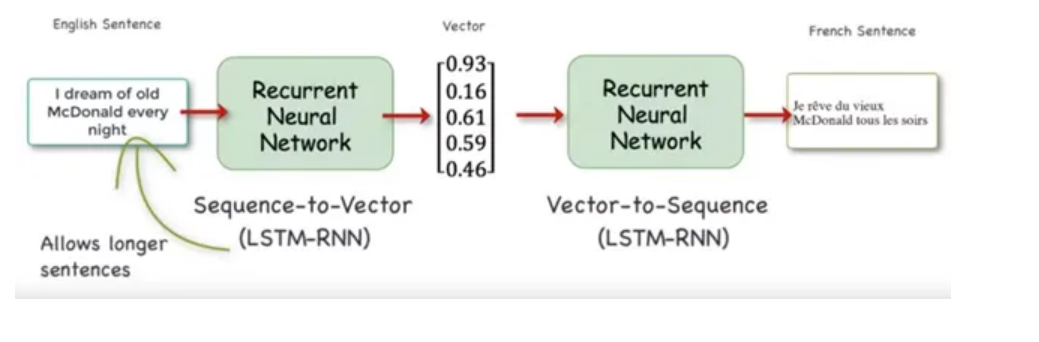[3]
### Drawback of a single directional encoder-decoder model is that it fails to predict complex long sentences to address this issue we can use bi-directional RNN's to undersrand the context of both future and past words thus increasing the accuracy of model.


### Attention mechanism proposed in [4] has been found to be really helpful for retaining context, attention mechanism is used to focus to specific parts of the input data to make accurate decision. In attention mechanism, the algorithm assigned a specific score to each token of input based on importance to the prediciton. These are learned during training and calculation of gradients during backpropogation.

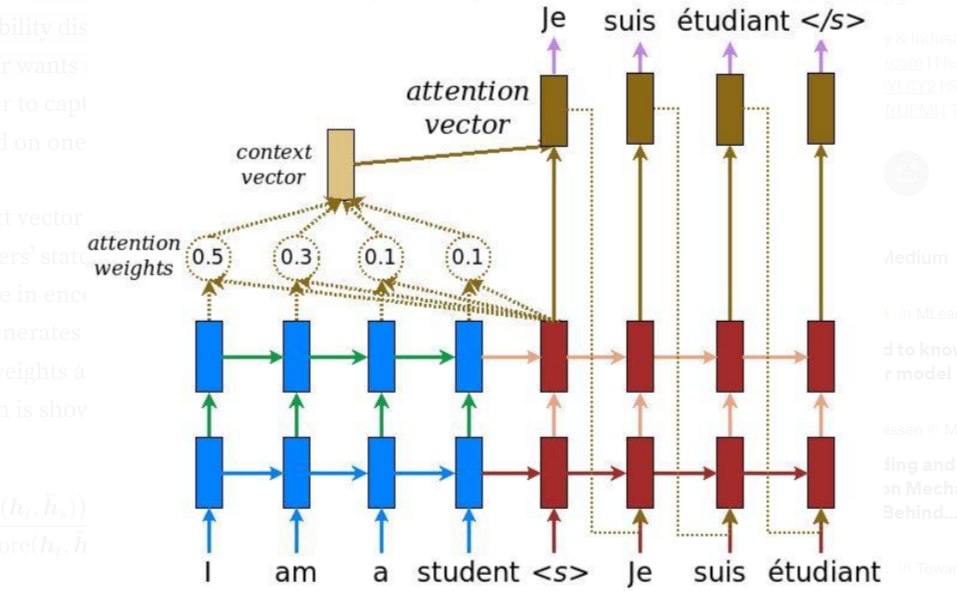[5]






# 1.2 Model training and comparing model with and without attention

## 1.2.1 Encoder Decoder:

### The sentences available in the corpus were varied from length of 30 sequences to a 100. The average bleu score for encoder-decooder model without attention was really close to zero. A bleu score of 1 indicates perfect translation (impossible to achieve) and 0 means the model is not able to genralize translations  at all. A blue score of 0.5 to 0.7 is considered to be good.

### While training the model on 5 epochs it can be observed that the model is overfitting as the train loss is decreasing constantly in each epoch but the validaiton loss is not decreasing after 2 or so epochs. Attention mechanism could be useful here as the sequence length of input text is large and attention weights could be used to rank and predict the target language

## 1.2.2 Encoder Decoder with attention

### Training a encoder-decoder model with attention mechanism came with its own set of challenges, mainly in computing resources. Training model on train_data for one epoch took approximately 50 minutes on Google Colab Pro and around 10  compute units, in the end it was impossible to fine tune the model as the GPU ran out and the CPU takes around 11 hours for one epoch. 

### Compared to model without attention this model was able to do relatively well in terms of bleu score. But, the blue score is relatively high becuase it was able to predict ther length of padding sequence, i.e the length of target sentences, in terms of translation it was not much better compared to a normal encoder-decoder . Maybe, it could perform better with fine tuning hyper paramerers like layers for LSTM, embedding size, number of epochs, etc.


[1] Alladin Perrson - torch Seq2Seq tutorial for Machine Translation (2020) YouTube. YouTube. Available at: https://www.youtube.com/watch?v=EoGUlvhRYpk&amp list=WL&index=3&t=471s (Accessed: April 2, 2023).

[2] CT5121 [Advance Natual Language Programming] Week 8 Lecture and Labs

[3] Asquith, N. (2019) Understanding neural machine translation: Encoder-decoder architecture, Medium. Towards Data Science. Available at: https://towardsdatascience.com/understanding-neural-machine-translation-encoder-decoder-architecture-80f205643ba4 (Accessed: April 2, 2023). 

[4] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. Advances in Neural Information Processing Systems, 30, 5998-6008.

[5] Synced (2017) A brief overview of attention mechanism, Medium. SyncedReview. Available at: https://medium.com/syncedreview/a-brief-overview-of-attention-mechanism-13c578ba9129 (Accessed: April 2, 2023). 



